In [18]:
import pandas as pd

# Load the dataset
df = pd.read_csv("station_data_dataverse.csv")

# 1. Fix timestamps (replace invalid '0014' year with '2014' and convert to datetime)
def fix_year(timestamp):
    return timestamp.replace("0014", "2014")

df['created'] = pd.to_datetime(df['created'].apply(fix_year), errors='coerce')
df['ended'] = pd.to_datetime(df['ended'].apply(fix_year), errors='coerce')

# 2. Impute missing distance values with the median
median_distance = df['distance'].median()
df['distance'].fillna(median_distance, inplace=True)

# 3. Flag outliers in chargeTimeHrs (> 12 hours)
df['isOutlier'] = df['chargeTimeHrs'] > 12

# 4. Convert 'weekday' and 'platform' to categorical
df['weekday'] = df['weekday'].astype('category')
df['platform'] = df['platform'].astype('category')

# (Optional) Save cleaned dataset
df.to_csv("Cleaned_EV_Charging_Sessions.csv", index=False)

print("✅ Data cleaning completed successfully.")


✅ Data cleaning completed successfully.


In [19]:
import pandas as pd

# Load raw dataset
df = pd.read_csv("station_data_dataverse.csv")

# Step 1: Fix known bad timestamp year ('0014' → '2014')
def fix_year_safe(ts):
    if pd.isna(ts): return ts
    return ts.replace("0014", "2014")

df['created'] = df['created'].apply(fix_year_safe)
df['ended'] = df['ended'].apply(fix_year_safe)

# Step 2: Convert to datetime
df['created'] = pd.to_datetime(df['created'], errors='coerce')
df['ended'] = pd.to_datetime(df['ended'], errors='coerce')

# Step 3: Ensure numeric charge time and distance
df['chargeTimeHrs'] = pd.to_numeric(df['chargeTimeHrs'], errors='coerce')
df['distance'] = pd.to_numeric(df['distance'], errors='coerce')

# Step 4: Recover missing timestamps using chargeTimeHrs
df.loc[df['ended'].isna() & df['created'].notna() & df['chargeTimeHrs'].notna(), 'ended'] = \
    df['created'] + pd.to_timedelta(df['chargeTimeHrs'] * 3600, unit='s')

df.loc[df['created'].isna() & df['ended'].notna() & df['chargeTimeHrs'].notna(), 'created'] = \
    df['ended'] - pd.to_timedelta(df['chargeTimeHrs'] * 3600, unit='s')

# Step 5: Drop rows missing both timestamps or duration
df = df.dropna(subset=['created', 'ended', 'chargeTimeHrs'])

# Step 6: Impute missing distance with median
median_distance = df['distance'].median()
df['distance'].fillna(median_distance, inplace=True)

# Step 7: Flag outliers (chargeTimeHrs > 12 hours)
df['isOutlier'] = df['chargeTimeHrs'] > 12

# Step 8: Extract time-based features
df['hour'] = df['created'].dt.hour
df['isWeekend'] = df['created'].dt.weekday >= 5
df['dayOfWeek'] = df['created'].dt.day_name()

# Step 9: Convert platform and weekday to category (if present)
for col in ['weekday', 'platform']:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Step 10: Final filter — keep only rows with all features needed for clustering
df = df.dropna(subset=['chargeTimeHrs', 'hour', 'isWeekend'])

# Step 11: Save cleaned dataset
df.to_csv("Cleaned_EV_Charging_Sessions_Final.csv", index=False)

print(" Final data cleaning complete.")
print(f" Cleaned dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")


 Final data cleaning complete.
 Cleaned dataset contains 23 rows and 28 columns.


C:\Users\rosem\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score: 0.38
Cluster Centers (scaled):
[[-0.16449166  0.83588056  0.        ]
 [-0.93088515 -0.76622385  0.        ]
 [ 1.23245319 -0.76622385  0.        ]]


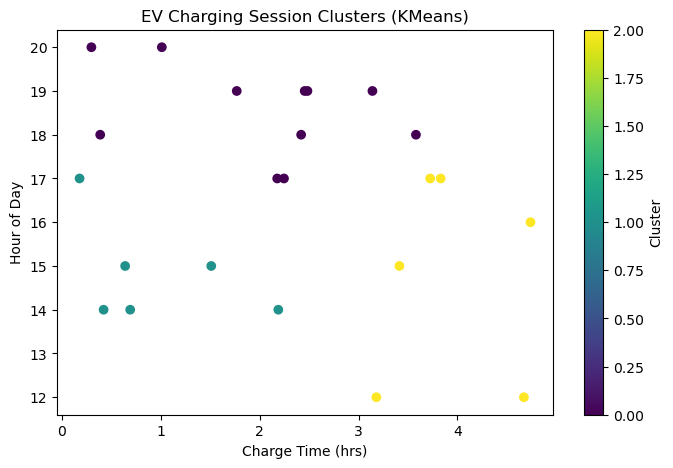

In [20]:
import os
os.environ["OMP_NUM_THREADS"] = "1"  # ✅ Must come before sklearn import

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


# --------- (Optional) Prevent MKL thread warning on Windows ---------
os.environ["OMP_NUM_THREADS"] = "1"

# Load cleaned dataset
df = pd.read_csv("Cleaned_EV_Charging_Sessions_Final.csv")

# --------- 1. Feature Selection ---------
df = df[df['chargeTimeHrs'].notna() & (df['chargeTimeHrs'] > 0)]

features = ['chargeTimeHrs']
if 'hour' in df.columns:
    features.append('hour')
if 'isWeekend' in df.columns:
    features.append('isWeekend')

df = df.dropna(subset=features)  # ensure features are complete
X = df[features]

# --------- 2. Normalize Features ---------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------- 3. Train KMeans with explicit n_init ---------
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_scaled)

df['cluster'] = labels

# --------- 4. Evaluate Model ---------
score = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {score:.2f}")
print("Cluster Centers (scaled):")
print(kmeans.cluster_centers_)

# --------- 5. Visualize Clusters ---------
plt.figure(figsize=(8, 5))
plt.scatter(df['chargeTimeHrs'], df['hour'], c=labels, cmap='viridis')
plt.xlabel("Charge Time (hrs)")
plt.ylabel("Hour of Day")
plt.title("EV Charging Session Clusters (KMeans)")
plt.colorbar(label="Cluster")
plt.show()


In [21]:
# Summary of cluster means
cluster_summary = df.groupby('cluster')[features].mean()
print("\nCluster behavior summary:")
print(cluster_summary)



Cluster behavior summary:
         chargeTimeHrs       hour  isWeekend
cluster                                     
0             1.996995  18.545455        0.0
1             0.938565  14.833333        0.0
2             3.926250  14.833333        0.0


normalised kmeans with more features


In [26]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- Preprocessing ---
df = pd.read_csv("Cleaned_EV_Charging_Sessions_Final.csv")

# Ensure 'created' is in datetime format
df['created'] = pd.to_datetime(df['created'], errors='coerce')

# Extract weekend info
df['isWeekend'] = df['created'].dt.weekday >= 5

# Clean and fill distance
df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
df['distance'].fillna(df['distance'].median(), inplace=True)

# Final feature list (without charger type)
features = ['chargeTimeHrs', 'hour', 'isWeekend', 'distance']

# Drop rows with missing values in selected features
df_clustering = df.dropna(subset=features)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering[features])

# Train KMeans
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Assign cluster labels
df_clustering['cluster'] = labels

# Evaluate clustering
score = silhouette_score(X_scaled, labels)
print(f"Silhouette Score (with enriched features): {score:.2f}")
print("Cluster Centers (scaled):")
print(kmeans.cluster_centers_)


C:\Users\rosem\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score (with enriched features): 0.38
Cluster Centers (scaled):
[[-1.64491657e-01  8.35880560e-01  0.00000000e+00  7.10542736e-15]
 [-9.30885151e-01 -7.66223846e-01  0.00000000e+00  7.10542736e-15]
 [ 1.23245319e+00 -7.66223846e-01  0.00000000e+00  7.10542736e-15]]


C:\Users\rosem\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\rosem\AppData\Local\Temp\ipykernel_20052\228599805.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering['cluster'] = labels


Silhouette Score (with enriched features): 0.42
Cluster Centers (scaled):
[[-0.85315876  0.16888199  0.          0.95742711]
 [ 1.02393679 -1.2121974   0.         -0.64408733]
 [ 0.60929463  0.6004693   0.         -1.04446594]]


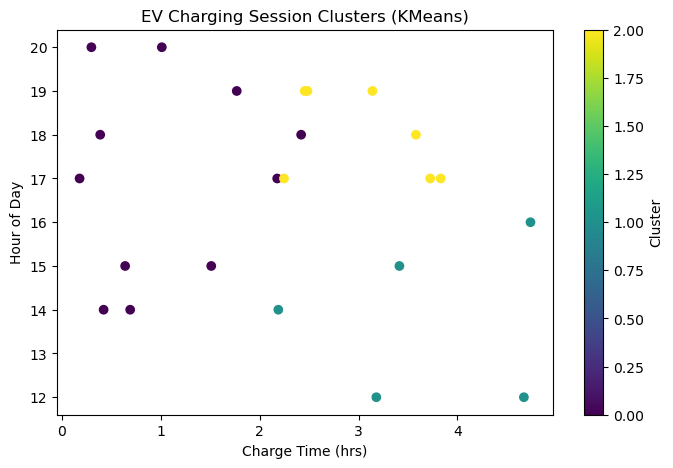

In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# --- Step 1: Load and Prepare Data ---
df = pd.read_csv("Cleaned_EV_Charging_Sessions.csv")

# Ensure datetime format for 'created'
df['created'] = pd.to_datetime(df['created'], errors='coerce')

# Extract time-based features
df['hour'] = df['created'].dt.hour
df['isWeekend'] = df['created'].dt.weekday >= 5

# Clean and fill distance
df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
df['distance'].fillna(df['distance'].median(), inplace=True)

# --- Step 2: Select and Filter Features ---
features = ['chargeTimeHrs', 'hour', 'isWeekend', 'distance']
df_clustering = df.dropna(subset=features)

# --- Step 3: Normalize Features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering[features])

# --- Step 4: Train KMeans ---
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_scaled)
df_clustering['cluster'] = labels

# --- Step 5: Evaluate ---
score = silhouette_score(X_scaled, labels)
print(f"Silhouette Score (with enriched features): {score:.2f}")
print("Cluster Centers (scaled):")
print(kmeans.cluster_centers_)

# --- Step 6: Visualize Clusters ---
plt.figure(figsize=(8, 5))
plt.scatter(df_clustering['chargeTimeHrs'], df_clustering['hour'], c=labels, cmap='viridis')
plt.xlabel("Charge Time (hrs)")
plt.ylabel("Hour of Day")
plt.title("EV Charging Session Clusters (KMeans)")
plt.colorbar(label="Cluster")
plt.show()

# --- Step 7: Export clustered data (optional) ---
# df_clustering.to_csv("Clustered_EV_Charging_Sessions.csv", index=False)
